# Pypho Case studies

This notebook illustrates the case-studies from the **pypho** paper.

 * [Case Study 1](#rock-sample-and-sharpness-zone) : Rock sample and sharpness zone optimization
 * [Case Study 2](#landscape-outcrop) : Drone flight on a large outcrop
 * [Case Study 3](#plug-sample-example) : Core plug, coverage and overlap
 
NB: This notebook is saved with static outputs, but you can get interactive output by running the cells.

<p style="text-align:left;">
    Previous page: <a href="./11_pypho_paper_figures.ipynb">Paper figures</a>
    <span style="float:right;">
    This is the last page.
    </span>
</p>

In [2]:
# this is to make pypho available from the local install
import sys
sys.path.append("..")

import pypho
print("Using PyPho version:", pypho.__version__)

## Rock sample and sharpness zone

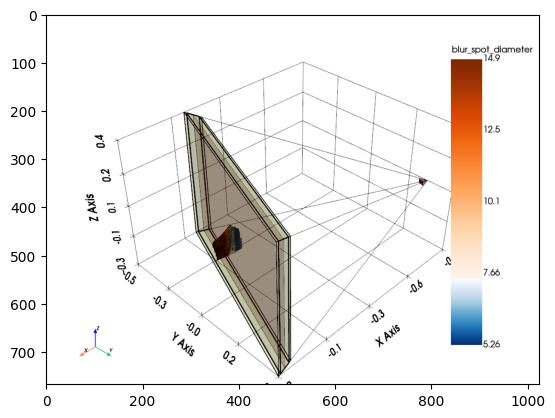

In [ ]:
import os
import pyvista as pv
from pypho import target, graphics, camera

# loading the dataset
data_dir = os.path.join("..","datasets","scheelite")
pv_obj = pv.read(os.path.join(data_dir,"scheelite.obj"))
texture = pv.read_texture(os.path.join(data_dir,"scheelite.jpg"))
obj = target.TargetObject(pv_obj)

# initialize the camera
cam = camera.get_default_camera()
cam.init_location(obj)
cam.attach_target(obj)
cam.orbit(-20)

# optimize the location to get a 10 pixel/mm resolution
cam.move_to(10, "resolution")

# optimize sharpness zone
cam.optimize_sharpness(
        target_points = obj.points,
        mode= "front", outside_weight= 100,
        optimize_N= True,
        use_diffraction= True
    )

# render the scene
viewer = graphics.Viewer3D(cameras= cam, objects= obj, target_object_texture= texture)
viewer.show()

# paint with the blur spot diameter
vmax = 2 * cam.confusion_circle_diameter * 1000
viewer.set_active_scalars("blur_spot_diameter", vmax= vmax, vertical= True,
    cmap= graphics.BlurSpotDiameterColormap(cam=cam, obj= obj, vmax= vmax, field= "blur_spot_diameter")
)

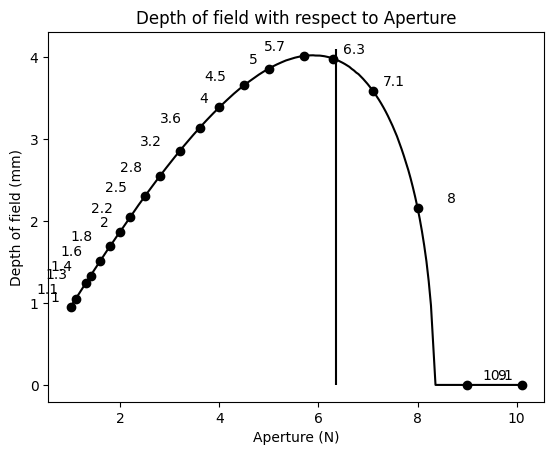

In [2]:
fig = graphics.plot_depth_of_field_vs_aperture(cam.copy(), N= cam.get_aperture_number_list(max_N=10, step=1/3) )
fig.axes[0].vlines(cam.N, 0,4.1, color= "k")

## Landscape Outcrop

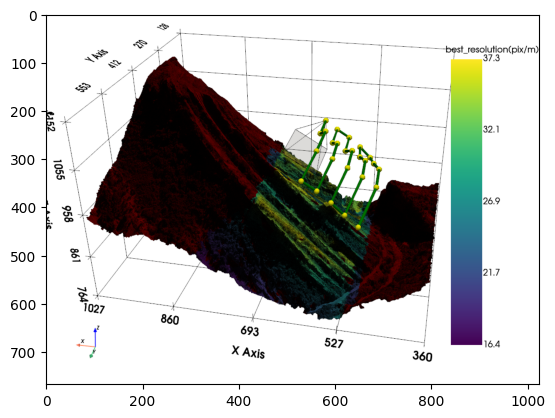

In [ ]:
import os
import pyvista as pv
from pypho import target, graphics, camera

# loading the dataset
data_dir = os.path.join("..","datasets","velodrome_1973")
pv_obj = pv.read(os.path.join(data_dir,"velodrome1973_part_cc44.obj"))
texture = pv.read_texture(os.path.join(data_dir,"velodrome1973_part_cc44.jpg"))
obj = target.TargetObject(pv_obj, kind= "Ground")

# creating a camera
drone = camera.CameraRegistry.get_camera("DJIM3pH", "DJIM3pH")
drone.init_location(obj)
drone.move_to([ 500,  600, 950 ])
drone.attach_target(obj, aim=False)
drone.turn(30, "up")
drone.move_to(100, "distance")

# creating a fine tuned viewer
viewer = graphics.Viewer3D(
    objects= obj, target_object_texture= texture,
    cameras= drone,
    plot_sharpness_object=False,
    plot_sharpness_object_edges=False,
    plot_diffraction_object=False,
    plot_diffraction_object_edges=False,
    plot_camera_location= True,
    plot_shot_location = True,
    camera_location_point_size_factor= 1,
    shot_location_point_size_factor=1,
    camera_location_color= "yellow",
    shot_location_color= "yellow",
    focus_plan_object_color= "grey"
)
viewer.show()

# adapting point of view
viewer.plotter.camera.position = (370,1715,1639)
viewer.plotter.camera.focal_point = (669, 450, 900)
viewer.plotter.camera.roll = 155
viewer.update()

# creating a flight path
inline_step = 100
nb_inline = 4
inter_line_step = 35
nb_line = 5
direction = "right"

drone.trigger(add_to_viewer=True, update_viewer= True)
for line in range(nb_line):
    for i in range(nb_inline):
        drone.move(inline_step, direction)
        drone.move_to(100, "distance")
        drone.trigger(add_to_viewer=True, update_viewer= True)
    if line != nb_line-1:
        drone.move(inter_line_step, "up")
        drone.move_to(100, "distance")
        drone.trigger(add_to_viewer=True, update_viewer= True)
        direction = "left" if direction == "right" else "right"
viewer.plot_flight_path(radius = 3, color= "green")

# showing the best resolution in pix/m
obj.point_data["best_resolution(pix/m)"] = obj.point_data["best_resolution"]*1000
viewer.set_active_scalars("best_resolution(pix/m)", vertical= True)

## Plug sample example

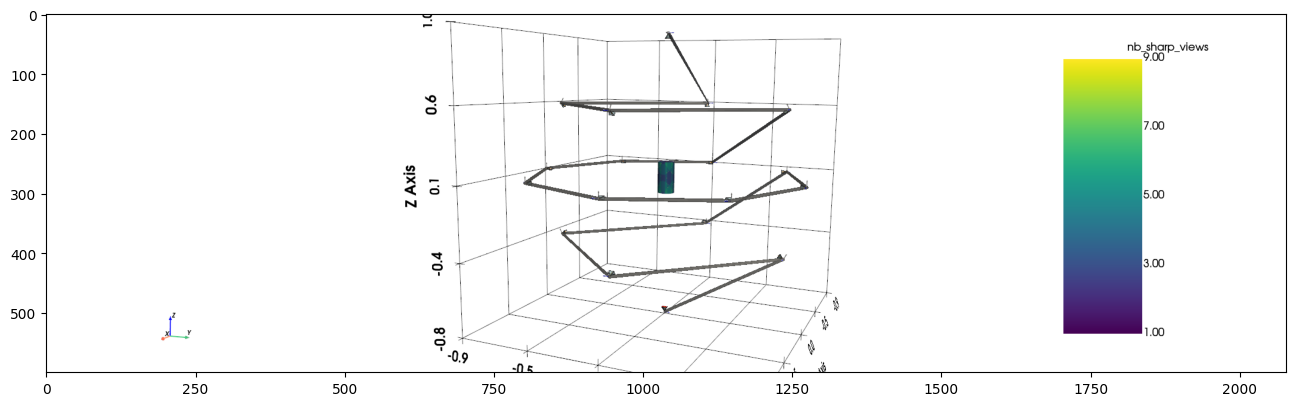

In [3]:
import pyvista as pv
from pypho import target, graphics, camera

# creating the dataset
obj = target.DrillCore(nsub= 5)
cam = camera.get_default_camera()
cam.init_location(obj)
cam.attach_target(obj)
viewer = graphics.Viewer3D(cameras=cam, objects=obj,
    plot_sharpness_object=False,
    plot_diffraction_object= False,
    plot_sharpness_object_edges=False,
    plot_diffraction_object_edges= False,
    plot_focus_plan_object= False,
    plot_view_frame_object= False,
    plot_shot_location= False,
    plot_shot_orientation= True)
viewer.show()

# setting camera position
viewer.plotter.camera.position = [3.8677038109991253, 1.716392120502972, 0.7313448701250325]
viewer.plotter.camera.focal_point = [0.0,0.0,0.0]
viewer.plotter.camera.roll = -95

# optimize location to get a sharp image
cam.optimize_sharpness(mode="middle", optimize_N= True, optimize_location= True)
init_location = cam.location

# path going from to to bottom with several levels (total 18 views)
#top
cam.update_view(location= init_location, yaw=0, pitch=0, roll=0)
cam.orbit(89.9, obj.center, [0,1,0])
cam.optimize_sharpness(mode="front", optimize_N= True, optimize_location= False)
cam.trigger(add_to_viewer=True, update_viewer= True)

# first level 4 views
cam.update_view(location= init_location, yaw=0, pitch=0, roll=0)
cam.orbit(30, obj.center, [0,1,0])
cam.optimize_sharpness(mode="front", optimize_N= True, optimize_location= False)
n=4
for i in range(n):
    cam.trigger(add_to_viewer=True, update_viewer= True)
    cam.orbit(360/n, around= obj.center)
    
# middle level 8 views
cam.update_view(location= init_location, yaw=0, pitch=0, roll=0)
cam.optimize_sharpness(mode="front", optimize_N= True, optimize_location= False)
n=8
for i in range(n):
    cam.trigger(add_to_viewer=True, update_viewer= True)
    cam.orbit(360/n, around= obj.center)
    
# last level 4 views
cam.update_view(location= init_location, yaw=0, pitch=0, roll=0)
cam.orbit(-30, obj.center, [0,1,0])
cam.optimize_sharpness(mode="front", optimize_N= True, optimize_location= False)
n=4
for i in range(n):
    cam.trigger(add_to_viewer=True, update_viewer= True)
    cam.orbit(360/n, around= obj.center)
    
#bottom
cam.update_view(location= init_location, yaw=0, pitch=0, roll=0)
cam.orbit(-89.9, obj.center, [0,1,0])
cam.optimize_sharpness(mode="front", optimize_N= True, optimize_location= False)
cam.trigger(add_to_viewer=True, update_viewer= True)

# showing the number of sharp views and flight path
viewer.set_active_scalars("nb_sharp_views", vmax= 9, vertical= True)
viewer.plot_flight_path(radius = 0.01, color= "grey", opacity= 0.8)

<p style="text-align:left;">
    Previous page: <a href="./11_pypho_paper_figures.ipynb">Paper figures</a>
    <span style="float:right;">
    This is the last page.
    </span>
</p>